Algoritmo Genetico para la Reproduccion de Imagenes. Este algoritmo reproduce una imagen usando un algoritmo genetico (AG) a traves de evolucionar valores de pixeles.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import random
import itertools
from PIL import Image

def img2chromosome(img_arr):
    """
    Convierte una imagen en un vector (cromosoma).
    """
    chromosome = np.reshape(a=img_arr,
                            newshape=(functools.reduce(operator.mul, img_arr.shape)))
    return chromosome

def chromosome2img(chromosome, img_shape):
    """
    Convierte un cromosoma en imagen con su forma original.
    """
    img_arr = np.reshape(a=chromosome, newshape=img_shape)
    return img_arr

def initial_population(img_shape, n_individuals=8):
    """
    Genera una población inicial aleatoria.
    """
    return np.random.randint(0, 256, size=(n_individuals, functools.reduce(operator.mul, img_shape)))

def fitness_fun(target_chrom, indiv_chrom):
    """
    Calcula la aptitud comparando la diferencia absoluta con la imagen objetivo.
    """
    quality = np.mean(np.abs(target_chrom - indiv_chrom))
    quality = np.sum(target_chrom) - quality
    return quality

def cal_pop_fitness(target_chrom, pop):
    """
    Calcula la aptitud de toda la población.
    """
    qualities = np.zeros(pop.shape[0])
    for indv_num in range(pop.shape[0]):
        qualities[indv_num] = fitness_fun(target_chrom, pop[indv_num])
    return qualities

def select_mating_pool(pop, qualities, num_parents):
    """
    Selecciona a los mejores individuos como padres.
    """
    parents = np.empty((num_parents, pop.shape[1]), dtype=np.uint8)
    for parent_num in range(num_parents):
        max_qual_idx = np.where(qualities == np.max(qualities))[0][0]
        parents[parent_num] = pop[max_qual_idx]
        qualities[max_qual_idx] = -1  # Evita repetir selección
    return parents

def crossover(parents, img_shape, n_individuals=8):
    """
    Cruza a los padres seleccionados para generar una nueva población.
    """
    new_population = np.empty(shape=(n_individuals, functools.reduce(operator.mul, img_shape)),
                              dtype=np.uint8)
    new_population[0:parents.shape[0]] = parents  # Mantiene a los mejores padres

    num_newly_generated = n_individuals - parents.shape[0]
    parents_permutations = list(itertools.permutations(iterable=np.arange(0, parents.shape[0]), r=2))

    selected_permutations = random.sample(range(len(parents_permutations)), num_newly_generated)

    comb_idx = parents.shape[0]
    for comb in range(len(selected_permutations)):
        selected_comb_idx = selected_permutations[comb]
        selected_comb = parents_permutations[selected_comb_idx]

        half_size = np.int32(new_population.shape[1] / 2)
        new_population[comb_idx + comb, 0:half_size] = parents[selected_comb[0], 0:half_size]
        new_population[comb_idx + comb, half_size:] = parents[selected_comb[1], half_size:]

    return new_population

def mutation(population, num_parents_mating, mut_percent):
    """
    Aplica mutación aleatoria a los genes de algunos individuos.
    """
    for idx in range(num_parents_mating, population.shape[0]):
        rand_idx = np.uint32(np.random.random(size=np.uint32(mut_percent / 100 * population.shape[1]))
                             * population.shape[1])
        new_values = np.uint8(np.random.random(size=rand_idx.shape[0]) * 256)
        population[idx, rand_idx] = new_values
    return population

def show_indivs(individuals, im_shape):
    """
    Muestra los individuos de la población como imágenes.
    """
    num_ind = individuals.shape[0]
    fig_row_col = 1
    for k in range(1, np.uint16(individuals.shape[0] / 2)):
        if np.floor(np.power(k, 2) / num_ind) == 1:
            fig_row_col = k
            break
    fig1, axis1 = plt.subplots(fig_row_col, fig_row_col)

    curr_ind = 0
    for idx_r in range(fig_row_col):
        for idx_c in range(fig_row_col):
            if curr_ind >= individuals.shape[0]:
                break
            else:
                curr_img = chromosome2img(individuals[curr_ind, :], im_shape)
                axis1[idx_r, idx_c].imshow(curr_img)
                curr_ind += 1

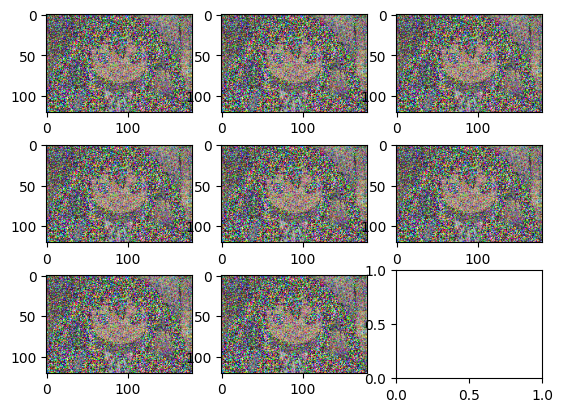

In [10]:
target_im = Image.open("/media/azusa.jpg").convert("RGB")
target_im = target_im.resize((180, 120))
target_im = np.array(target_im)
target_chromosome = img2chromosome(target_im)

# Population size
sol_per_pop = 8
# Mating pool size
num_parents_mating = 4
# Mutation percentage
mutation_percent = .01


# Creating an initial population randomly.
new_population = initial_population(img_shape=target_im.shape,
                                         n_individuals=sol_per_pop)

for iteration in range(50000):
    # Measing the fitness of each chromosome in the population.
    qualities = cal_pop_fitness(target_chromosome, new_population)

    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, qualities,
                                      num_parents_mating)

    # Generating next generation using crossover.
    new_population = crossover(parents, target_im.shape,
                                    n_individuals=sol_per_pop)

    new_population = mutation(population=new_population,
                                   num_parents_mating=num_parents_mating,
                                   mut_percent=mutation_percent)

# Display the final generation
show_indivs(new_population, target_im.shape)